In [17]:
import torch
import torch.nn.functional as F
from transformers import BertForSequenceClassification, BertTokenizer

# =========================
# KONFIGURASI
# =========================
model_dir = r"D:\coding\python\indonlu\model_price"   # ganti sesuai folder model terbaik
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# LOAD MODEL & TOKENIZER
# =========================
tokenizer = BertTokenizer.from_pretrained(model_dir, local_files_only=True)
model = BertForSequenceClassification.from_pretrained(model_dir, local_files_only=True)
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
i2w = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

In [19]:
text = "rasanya enak banget perutku sampai sakit broh pelayannya biasa harganya sangat murah"

# Tokenisasi
inputs = tokenizer(
    text,
    return_tensors="pt",
    truncation=True,
    max_length=128
)

# Pindahkan ke device
inputs = {k: v.to(device) for k, v in inputs.items()}

# Forward model
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Prediksi
probs = F.softmax(logits, dim=-1)
label_id = torch.argmax(probs, dim=-1).item()
confidence = probs[0, label_id].item() * 100

print(f"Text  : {text}")
print(f"Label : {i2w[label_id]} ({confidence:.2f}%)")

Text  : rasanya enak banget perutku sampai sakit broh pelayannya biasa harganya sangat murah
Label : positive (97.74%)


Classification Report:

              precision    recall  f1-score   support

    negative     0.7742    0.8276    0.8000        29
     neutral     0.9091    0.6452    0.7547        31
    positive     0.7632    0.9355    0.8406        31

    accuracy                         0.8022        91
   macro avg     0.8155    0.8027    0.7984        91
weighted avg     0.8164    0.8022    0.7984        91



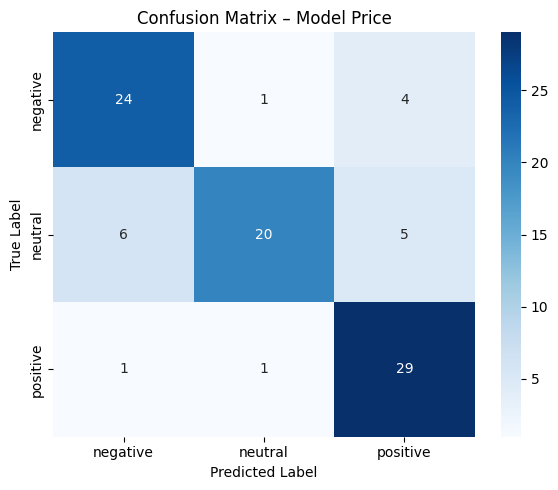


Hasil prediksi disimpan ke: prediction_vs_truth.csv


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# KONFIGURASI
# =========================
pred_csv = "../dataset/fnb/price/test_preprocess_masked_label.csv"
gt_csv = "../dataset/fnb/price/test_preprocess.csv"


# Label Mapping
label2id = {v: k for k, v in i2w.items()}
id2label = i2w

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# LOAD MODEL & TOKENIZER
# =========================
tokenizer = BertTokenizer.from_pretrained(model_dir, local_files_only=True)
model = BertForSequenceClassification.from_pretrained(model_dir, local_files_only=True)
model.to(device)
model.eval()

# =========================
# LOAD DATA
# =========================
df_pred = pd.read_csv(pred_csv)
df_gt = pd.read_csv(gt_csv)

assert len(df_pred) == len(df_gt), "Jumlah data prediksi & ground truth HARUS sama"

sentences = df_pred["sentence"].tolist()

# =========================
# PREDIKSI MODEL
# =========================
y_pred = []

with torch.no_grad():
    for text in sentences:
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=128
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs)
        logits = outputs.logits
        pred_id = torch.argmax(F.softmax(logits, dim=-1), dim=-1).item()

        y_pred.append(pred_id)

# =========================
# LABEL ASLI
# =========================
y_true = df_gt["label"].map(label2id).tolist()

# =========================
# CONFUSION MATRIX
# =========================
labels = ["negative", "neutral", "positive"]
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=labels,
    digits=4
))

# =========================
# VISUALISASI
# =========================
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Model Price")
plt.tight_layout()
plt.show()

# =========================
# SIMPAN HASIL PREDIKSI
# =========================
df_result = df_pred.copy()
df_result["predicted_label"] = [id2label[i] for i in y_pred]
df_result["true_label"] = df_gt["label"]

df_result.to_csv("prediction_vs_truth.csv", index=False)
print("\nHasil prediksi disimpan ke: prediction_vs_truth.csv")